<a href="https://colab.research.google.com/github/i2mmmmm/Study/blob/main/image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 64
image_size = 64
num_epochs = 100
batch_size = 64
sample_dir = '/content/drive/My Drive/generated_images'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


# 이미지가 저장된 경로 설정
image_path = '/content/sculpture/'

# Custom dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return 20  # Assuming you have 20 images

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{idx + 1}.PNG')
        image = Image.open(img_name).convert('RGB')  # 이미지를 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image

# Load the dataset
dataset = CustomDataset(root_dir=image_path, transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, hidden_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 8, hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Initialize the generator
generator = Generator().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, images in enumerate(data_loader):
        images = images.to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # ================================================================== #
        #                      Train the generator                           #
        # ================================================================== #

        # Generate fake images
        z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
        fake_images = generator(z)

        # Compute the generator loss
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Generator Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, g_loss.item()))

    # Save sampled images
    if (epoch+1) % 10 == 0:
        save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints
torch.save(generator.state_dict(), '/content/sculpture/generator.ckpt')

NameError: name 'discriminator' is not defined

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 128
image_size = 32
num_epochs = 100
batch_size = 64
sample_dir = 'generated_images'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# CIFAR-10 dataset
dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, hidden_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size, hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 2, hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Initialize the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(images.size(0)).to(device)
        fake_labels = torch.zeros(images.size(0)).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCE_Loss using fake images
        z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # ================================================================== #
        #                      Train the generator                           #
        # ================================================================== #

        # Compute the generator loss
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D Loss: {:.4f}, G Loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save sampled images
    if (epoch+1) % 10 == 0:
        save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints
torch.save(generator.state_dict(), 'generator.ckpt')
torch.save(discriminator.state_dict(), 'discriminator.ckpt')


Files already downloaded and verified
Epoch [1/100], Step [200/782], D Loss: 0.5146, G Loss: 4.8957, D(x): 2.36, D(G(z)): -1.47
Epoch [1/100], Step [400/782], D Loss: 0.6248, G Loss: 3.4012, D(x): 1.78, D(G(z)): -1.15
Epoch [1/100], Step [600/782], D Loss: 0.5723, G Loss: 3.6681, D(x): 1.93, D(G(z)): -1.67


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Epoch [2/100], Step [200/782], D Loss: 0.4786, G Loss: 4.0055, D(x): 2.74, D(G(z)): -1.23
Epoch [2/100], Step [400/782], D Loss: 0.3894, G Loss: 3.1629, D(x): 2.27, D(G(z)): -1.71
Epoch [2/100], Step [600/782], D Loss: 0.3269, G Loss: 3.9828, D(x): 4.14, D(G(z)): -1.38
Epoch [3/100], Step [200/782], D Loss: 0.4870, G Loss: 3.4897, D(x): 2.17, D(G(z)): -1.70
Epoch [3/100], Step [400/782], D Loss: 0.2613, G Loss: 3.5533, D(x): 2.37, D(G(z)): -2.44
Epoch [3/100], Step [600/782], D Loss: 0.6366, G Loss: 3.7592, D(x): 0.36, D(G(z)): -5.28
Epoch [4/100], Step [200/782], D Loss: 0.2323, G Loss: 3.0967, D(x): 2.22, D(G(z)): -2.90
Epoch [4/100], Step [400/782], D Loss: 0.2641, G Loss: 4.0274, D(x): 1.93, D(G(z)): -4.42
Epoch [4/100], Step [600/782], D Loss: 0.9599, G Loss: 4.4231, D(x): 0.14, D(G(z)): -5.47
Epoch [5/100], Step [200/782], D Loss: 0.3123, G Loss: 3.1398, D(x): 1.69, D(G(z)): -3.45
Epoch [5/100], Step [400/782], D Loss: 0.0860, G Loss: 4.2311, D(x): 3.24, D(G(z)): -4.19
Epoch [5/1

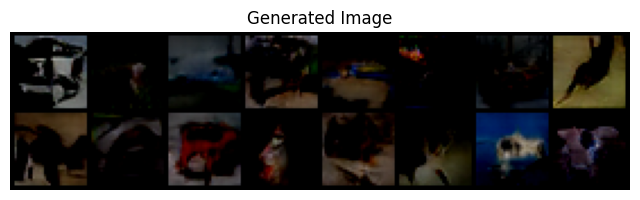

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = '/content/generated_images/fake_images-100.png'

# 이미지 열기
img = Image.open(image_path)

# matplotlib를 사용하여 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.title('Generated Image')  # 제목 추가
plt.show()

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 128
image_size = 32
num_epochs = 100
batch_size = 64
sample_dir = 'generated_images'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# CIFAR-10 dataset with specific category (Dog)
class_specific_category = 'Dog'  # Specify the category you want to train on
class_specific_index = 5  # Index of the 'dog' category in CIFAR-10 dataset

dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)

# Filter dataset to include only images from the specific category
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == class_specific_index]
filtered_dataset = torch.utils.data.Subset(dataset, dog_indices)

data_loader = DataLoader(dataset=filtered_dataset, batch_size=batch_size, shuffle=True)

# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, hidden_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size, hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 2, hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Initialize the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(images.size(0)).to(device)
        fake_labels = torch.zeros(images.size(0)).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCE_Loss using fake images
        z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # ================================================================== #
        #                      Train the generator                           #
        # ================================================================== #

        # Compute the generator loss
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D Loss: {:.4f}, G Loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save sampled images
    if (epoch+1) % 10 == 0:
        save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints
torch.save(generator.state_dict(), 'generator_dog.ckpt')
torch.save(discriminator.state_dict(), 'discriminator_dog.ckpt')

100%|██████████| 170498071/170498071 [00:15<00:00, 11313531.60it/s]


Extracting data/cifar-10-python.tar.gz to data/


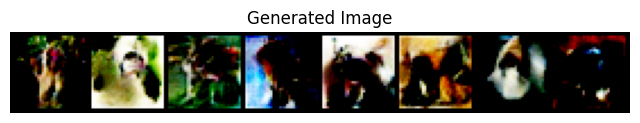

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = '/content/generated_images/fake_images-100.png'

# 이미지 열기
img = Image.open(image_path)

# matplotlib를 사용하여 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.title('Generated Image')  # 제목 추가
plt.show()

Files already downloaded and verified


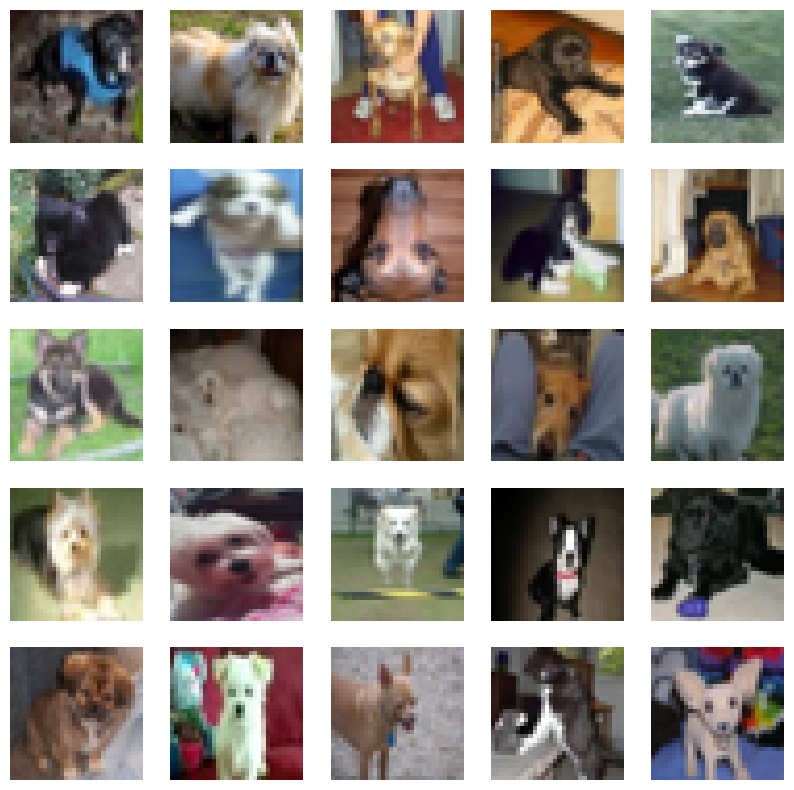

In [3]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# CIFAR-10 dataset
dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)

# Define the class index for 'dog' in CIFAR-10
class_specific_index = 5  # Index for 'dog'

# Filter dataset to include only images from the 'dog' category
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == class_specific_index]
dog_images = [dataset[i][0] for i in dog_indices]

# Function to denormalize and convert tensor to numpy array for plotting
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # De-normalize
    return tensor.numpy()

# Plot a few 'dog' images
def show_images(images, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(10, 10))
    for i in range(nrow * ncol):
        img = denormalize(images[i])
        img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
        axes[i // ncol, i % ncol].imshow(img)
        axes[i // ncol, i % ncol].axis('off')
    plt.show()

# Show the first 25 'dog' images
show_images(dog_images[:25])

Files already downloaded and verified


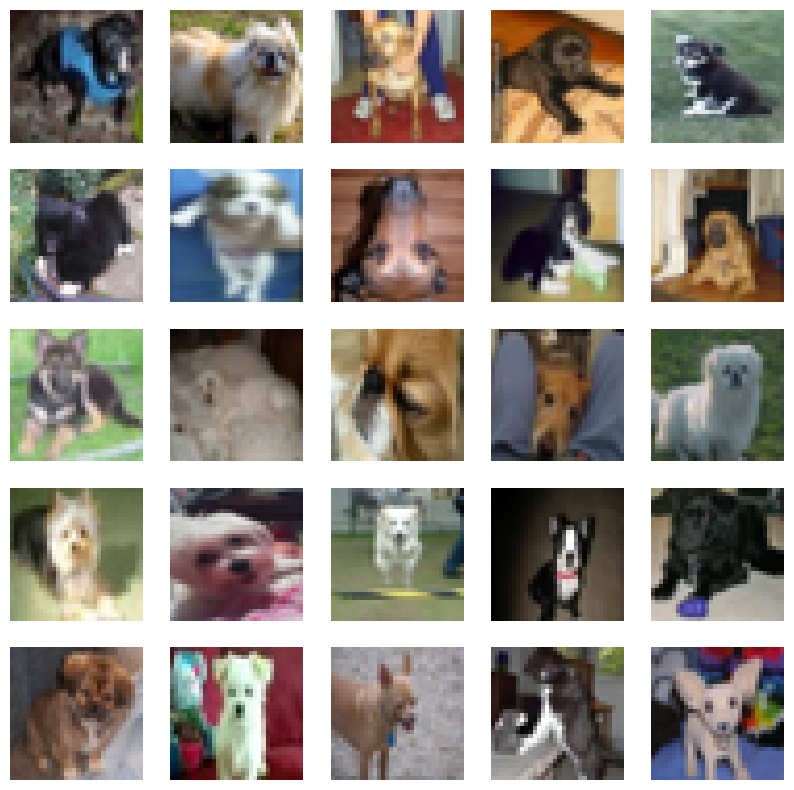

In [5]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# CIFAR-10 dataset
dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)

# Define the class index for 'dog' in CIFAR-10
class_specific_index = 5  # Index for 'dog'

# Filter dataset to include only images from the 'dog' category
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == class_specific_index]
dog_images = [dataset[i][0] for i in dog_indices]

# Function to denormalize and convert tensor to PIL image
def denormalize_and_to_pil(tensor):
    tensor = tensor * 0.5 + 0.5  # De-normalize
    tensor = tensor.clamp(0, 1)  # Ensure the values are within [0, 1]
    return to_pil_image(tensor)

# Plot a few 'dog' images
def show_images(images, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(10, 10))
    for i in range(nrow * ncol):
        img = denormalize_and_to_pil(images[i])
        axes[i // ncol, i % ncol].imshow(img)
        axes[i // ncol, i % ncol].axis('off')
    plt.show()

# Show the first 25 'dog' images
show_images(dog_images[:25])

In [4]:
# 데이터 증강
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),  # 증강 추가
    transforms.RandomCrop(image_size, padding=4),  # 증강 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드
dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == class_specific_index]
filtered_dataset = torch.utils.data.Subset(dataset, dog_indices)
data_loader = DataLoader(dataset=filtered_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [6]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0)).to(device)
        fake_labels = torch.zeros(images.size(0)).to(device)

        # 판별기 훈련
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # 판별기 스텝당 생성기를 여러 번 훈련
        for _ in range(2):
            z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D Loss: {:.4f}, G Loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    if (epoch+1) % 10 == 0:
        save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(generator.state_dict(), 'generator_dog.ckpt')
torch.save(discriminator.state_dict(), 'discriminator_dog.ckpt')

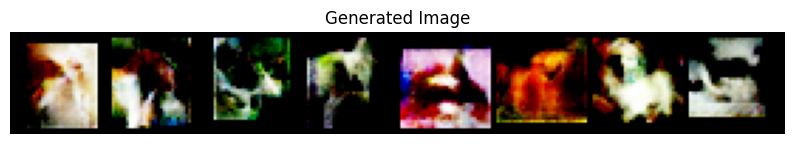

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = '/content/generated_images/fake_images-100.png'

# 이미지 열기
img = Image.open(image_path)

# matplotlib를 사용하여 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.title('Generated Image')  # 제목 추가
plt.show()